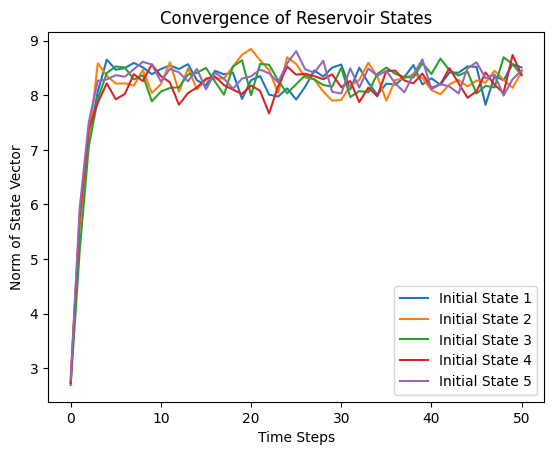

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming a simple reservoir setup
def reservoir_update(W, Win, res_state, input_signal):
    return np.tanh(np.dot(W, res_state) + np.dot(Win, input_signal))

# Example parameters
num_units = 100
W = np.random.rand(num_units, num_units) - 0.5
Win = np.random.rand(num_units, 1) - 0.5
input_signal = np.random.rand(1) - 0.5
time_steps = 50

# Initial states
initial_states = [np.random.rand(num_units) - 0.5 for _ in range(5)]
reservoir_states = [initial_states.copy()]

for t in range(time_steps):
    next_states = []
    for state in reservoir_states[-1]:
        next_state = reservoir_update(W, Win, state, input_signal)
        next_states.append(next_state)
    reservoir_states.append(next_states)

# Plotting convergence of states
for i, state_trajectory in enumerate(zip(*reservoir_states)):
    plt.plot([np.linalg.norm(state) for state in state_trajectory], label=f'Initial State {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Norm of State Vector')
plt.legend()
plt.title('Convergence of Reservoir States')
plt.show()

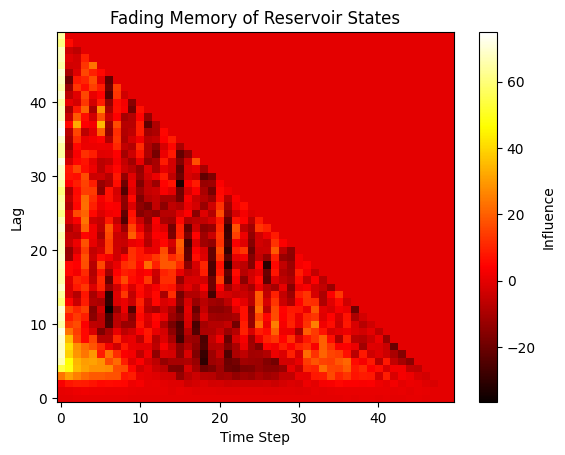

In [2]:
# Generating a structured input sequence
input_sequence = np.sin(np.linspace(0, 10, time_steps)) + np.random.normal(0, 0.1, time_steps)
res_state = np.zeros(num_units)
reservoir_states = []

for t in range(time_steps):
    input_signal = np.array([input_sequence[t]])
    res_state = reservoir_update(W, Win, res_state, input_signal)
    reservoir_states.append(res_state)

# Plotting the influence of past inputs
influence_matrix = np.zeros((time_steps, time_steps))
for t in range(time_steps):
    for tau in range(time_steps - t):
        influence_matrix[t, tau] = np.dot(reservoir_states[t], reservoir_states[t + tau])

plt.imshow(influence_matrix, aspect='auto', cmap='hot', origin='lower')
plt.colorbar(label='Influence')
plt.xlabel('Time Step')
plt.ylabel('Lag')
plt.title('Fading Memory of Reservoir States')
plt.show()

In [3]:
from Utils.DataLoader import loadData
import pandas as pd
from reservoirpy.nodes import Reservoir, Ridge, ESN
from reservoirpy.datasets import to_forecasting
import numpy as np
import matplotlib.pyplot as plt
import torch

problem = "MackeyGlass"
(input_fit, target_fit), (input_gen, target_gen), scaler = loadData(problem, version=6)
io_size = input_fit.size(1)
n_input_gen = input_gen.size(0)
input_fit = input_fit.unsqueeze(0)
target_fit = target_fit.unsqueeze(0)
input_gen = input_gen.unsqueeze(0)
n_gen = target_gen.size(0)

units = 500
leak_rate = 0.3
spectral_radius = 0.9
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-4

variables = 1

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                  lr=leak_rate, rc_connectivity=connectivity,
                  input_connectivity=input_connectivity)

readout = Ridge(variables, ridge=regularization)

esn = ESN(reservoir=reservoir, readout=readout, workers=-1)

# train the ESN
esn.fit(input_fit, target_fit)

_, h = esn(input_gen)
X_gen = np.zeros((target_gen.size(0), variables))
y = input_gen[:, -1, :].cpu().numpy()
for i in range(target_gen.size(0)):
    input = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
    output, h = esn(input, h)
    y = output[:, 0, :].cpu().numpy()
    z = output[0, 0, :].cpu().numpy()
    X_gen[i] = z

# plot the data
plt.figure(figsize=(15, 10))
plt.plot(range(n_input_gen), input_gen[0, :, 0], label='Input')
plt.plot(range(n_input_gen, n_input_gen + n_gen), target_gen[:, 0], label="True", linestyle="--")
plt.plot(range(n_input_gen, n_input_gen + n_gen), X_gen[:, 0], label='Generated')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.show()


TypeError: Data type '<class 'torch.Tensor'>' not understood. All vectors should be Numpy arrays in Reservoir-0.